In [207]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cluster import KMeans
from sklearn import datasets

from scipy.spatial.distance import cdist, euclidean
from scipy.stats import percentileofscore

pd.set_option('display.max_columns', None)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [251]:
#df = pd.read_csv("combined.csv")
df = pd.read_csv("combined.csv")
df.head(10)

,Unnamed: 0,Date/Time,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Our Score - End of Point,Their Score - End of Point,Event Type,Action,Passer,Receiver,Defender,Hang Time (secs),Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Player 19,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs),Team
0,0,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,Kyle S,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AtlantaHustle
1,1,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,Dylan T,J Clark,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,AtlantaHustle
2,2,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,J Clark,B Hannah,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,AtlantaHustle
3,3,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,B Hannah,B. Moore,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,AtlantaHustle
4,4,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,B. Moore,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,AtlantaHustle
5,5,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Goal,Dylan T,Matt S,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,AtlantaHustle
6,6,2015-04-12 13:09,NaN,Charlotte Express,9,D,1,1,Defense,Pull,NaN,NaN,R Runner,6.206,TGoforth,R James,R Runner,S. Hicks,Archie,B. Liu,Jack K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,AtlantaHustle
7,7,2015-04-12 13:09,NaN,Charlotte Express,9,D,1,1,Defense,Goal,NaN,NaN,Anonymous,NaN,TGoforth,R James,R Runner,S. Hicks,Archie,B. Liu,Jack K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,AtlantaHustle
8,8,2015-04-12 13:09,NaN,Charlotte Express,53,O,2,1,Offense,Catch,F Wooten,Dylan T,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,AtlantaHustle
9,9,2015-04-12 13:09,NaN,Charlotte Express,53,O,2,1,Offense,Catch,Dylan T,J Clark,NaN,NaN,Kyle S,Dylan T,Matt S,B Hannah,J Clark,F Wooten,B. Moore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138,AtlantaHustle


In [265]:
# clean up time data
pts = np.array(df["Point Elapsed Seconds"])
cutoff = np.percentile(pts, 99.5) + 100
mean_point_length = np.mean(pts)
np.vectorize(pts, lambda x: x if x < cutoff else mean_point_length)
df["Point Elapsed Seconds"] = pts

ValueError: Invalid otype specification

In [209]:
actions = set(df["Action"])
print "There are the possible actions that can occur ", actions
# get the actions that can start a point, cause a turn, or end a point.
actions_start = ["Pull", "PullOb", "OpponentPull", "OpponentPullOb"]
actions_turn = ["Stall", "Throwaway", "D", "Drop"]
actions_end = ["EndOfThirdQuarter", 'EndOfFirstQuarter', "Goal", "GameOver",
               "HalfTime", "Callahan", "EndOfFourthQuarter", "End of Overtime"]

There are the possible actions that can occur  set(['EndOfThirdQuarter', 'Pull', 'EndOfFirstQuarter', 'PullOb', 'Goal', 'GameOver', 'OpponentCatch', 'Drop', 'OpponentPull', 'OpponentPullOb', 'Halftime', 'Stall', 'MiscPenalty', 'Callahan', 'Catch', 'EndOfFourthQuarter', 'Throwaway', 'EndOfOvertime', 'D'])


In [219]:
# beginning df structure
cols = {"team": [], "offense": [], "turns" : [], "pull-ob": [], "ds":[], "won": [], "point_time": [], "num_throws":[]}

# names of columns in df made easier.
ours = "Our Score - End of Point"
theirs = "Their Score - End of Point"

# for each throw, determine if it's the end of a point, or a turn, and update accordingly
def parse_throw(row):
    if parse_throw.newpt:
        cols["team"] += [row.Team]
        cols["offense"].append(row.Line == 'O')
        cols["turns"] += [0]
        cols["ds"] += [0]
        cols["pull-ob"].append(row.Action == "PullOb" or row.Action == "OpponentPullOb")
        cols["point_time"] += [row["Point Elapsed Seconds"]]
        cols["num_throws"] += [0]
        parse_throw.index += 1
        if parse_throw.prev == row[ours] - 1:
            cols["won"] += [True]
        elif parse_throw.prev_opp == row[theirs] - 1:
            cols["won"] += [False]
        else:
            cols["won"] += [row[ours] == 1]
    if row.Action in actions_turn:
        cols["turns"][parse_throw.index-1] += 1
    if row.Action == "D":
        cols["ds"][parse_throw.index-1] += 1
    cols["num_throws"][parse_throw.index-1] += 1
    parse_throw.newpt = (row.Action in actions_end)
    parse_throw.prev = row[ours]
    parse_throw.prev_opp = row[theirs]
# set default values for some fuction params
parse_throw.index = 0
parse_throw.num_throws = 0
parse_throw.prev = None
parse_throw.prev_opp = None
parse_throw.newpt = True

# apply and create our new df.
df.apply(lambda x: parse_throw(x), axis=1)
points = pd.DataFrame(cols)

In [220]:
points.head(5)

,ds,num_throws,offense,point_time,pull-ob,team,turns,won
0,0,6,True,27,False,AtlantaHustle,0,True
1,0,2,False,9,False,AtlantaHustle,0,False
2,0,12,True,53,False,AtlantaHustle,0,True
3,0,9,False,54,False,AtlantaHustle,1,True
4,0,3,False,27,False,AtlantaHustle,1,True


In [225]:
Xall=points[['turns', 'ds']].values
from sklearn.mixture import GMM
n_clusters=2
clfgmm = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm.fit(Xall)
print clfgmm
gmm_means=clfgmm.means_
gmm_covar=clfgmm.covars_
print gmm_means, gmm_covar

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 4.70691983  1.00124591]
 [ 0.74518905  0.19676564]] [[ 1.01157322  0.28019221]
 [ 0.28019221  0.23786601]]


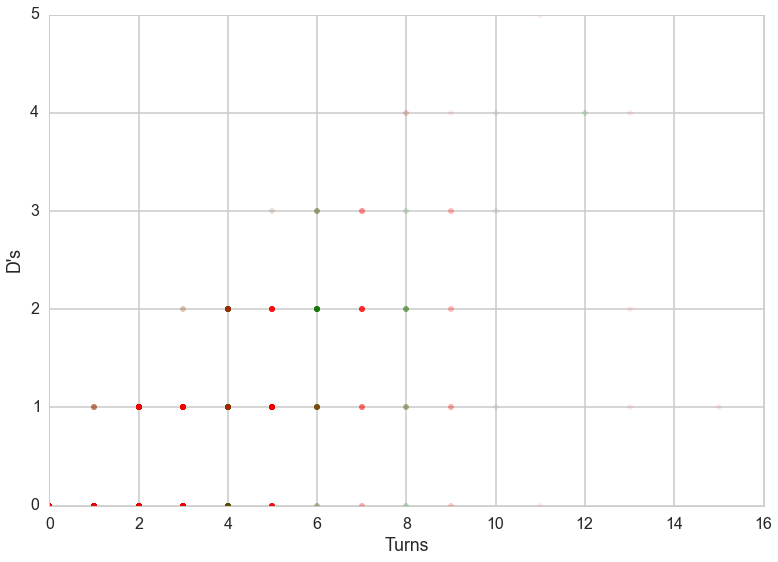

In [226]:
mask_hold = points.apply( lambda x :(x.offense == True and x.won == True), axis=1)
mask_break = points.apply( lambda x :(x.offense == True and x.won == False), axis=1)
plt.plot(points[mask_hold].turns, points[mask_hold].ds, '.', alpha=0.08, c='g')
plt.plot(points[mask_break].turns, points[mask_break].ds, '.', alpha=0.08, c='r')

plt.xlabel("Turns")
plt.ylabel("D's")


In [227]:
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)


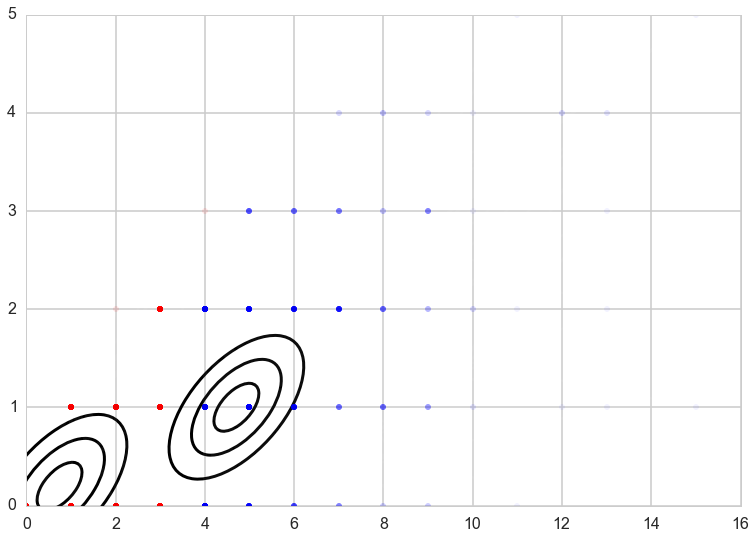

In [228]:
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
gmm_labels=clfgmm.predict(Xall)

for k, col in zip(range(n_clusters), ['blue','red']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)

## Analysis

This clustering therefore does not demarkate breaks, but instead indicates good and bad points.  However, the problem that is not solved is determine of those that are clustered in red, which ones are exciting points, and which of those are actually turn-filled points because of sloppy play or bad weather.

In [244]:
# try using k means
cluster_cols = points[["turns", "ds", "point_time"]]
model = KMeans(n_clusters=50).fit(cluster_cols.values)
points["cluster"] = model.labels_
points.groupby("cluster").count()

,ds,num_throws,offense,point_time,pull-ob,team,turns,won
cluster,,,,,,,,
0,1368,1368,1368,1368,1368,1368,1368,1368
1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,229,229,229,229,229,229,229,229
8,2,2,2,2,2,2,2,2


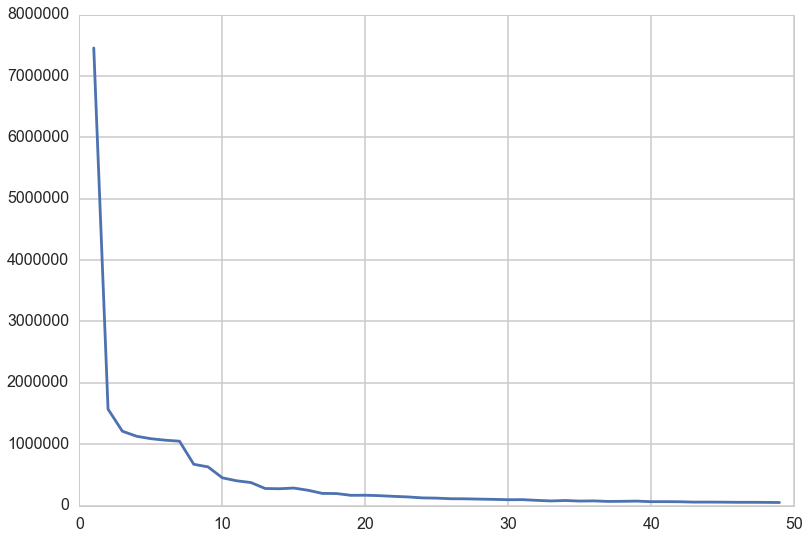

In [245]:
num_clusters = range(1, 50)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)

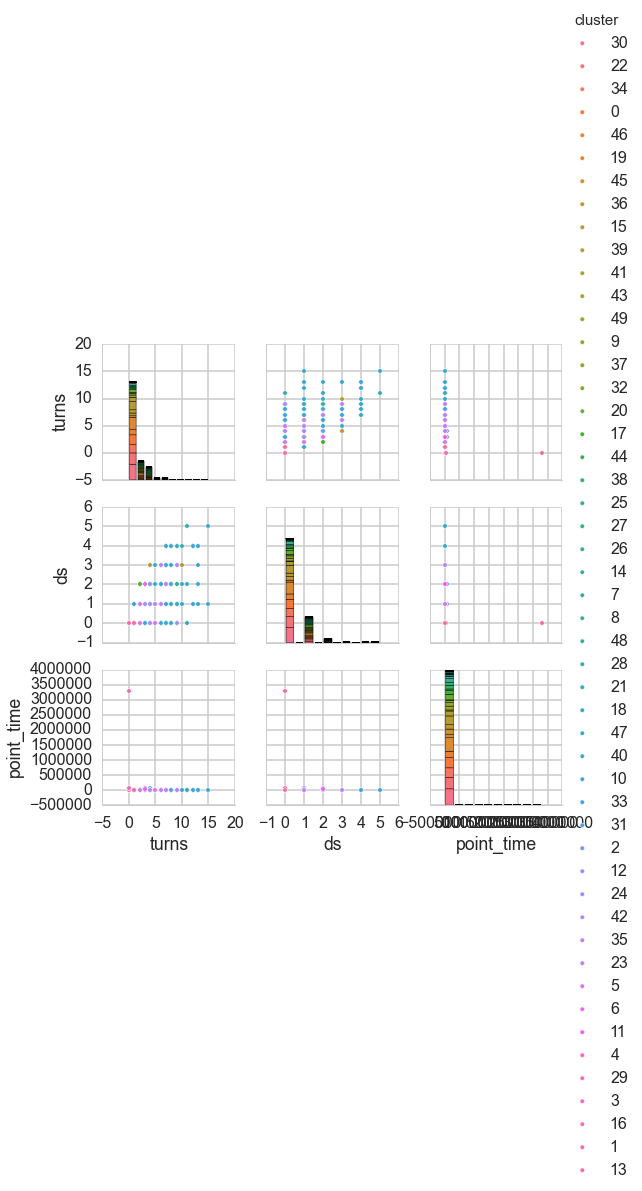

In [246]:
sns.pairplot(points, vars=["turns", "ds", "point_time"], hue="cluster")